In [64]:
import os, sys
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm import tqdm
from matplotlib.colors import LinearSegmentedColormap

# Add parent directory to system path
notebook_dir = os.getcwd()
parent_dir = os.path.dirname(notebook_dir)
sys.path.append(os.path.join(parent_dir, 'core'))

# Import from core directory
from algorithms import GD, ExpGD, EnsemblingModel, QuantileTracker
from utils import set_randomness

In [65]:
class PinballLoss():

  def __init__(self, quantile=0.10, reduction='mean'):
      self.quantile = quantile
      assert 0 < self.quantile
      assert self.quantile < 1
      self.reduction = reduction

  def __call__(self, output, target):
      assert output.shape == target.shape
      loss = torch.zeros_like(target, dtype=torch.float)
      error = output - target
      smaller_index = error < 0
      bigger_index = 0 < error
      loss[smaller_index] = self.quantile * (abs(error)[smaller_index])
      loss[bigger_index] = (1-self.quantile) * (abs(error)[bigger_index])

      if self.reduction == 'sum':
        loss = loss.sum()
      if self.reduction == 'mean':
        loss = loss.mean()

      return loss

In [ ]:
# Set flags and parameters
experiment_name = "quantile_ensembling"
show_f = False
save = True
show = False

# Set randomness
set_randomness(0)

# Load and preprocess data
data = pd.read_pickle('./.cache/gradient_boosting.pkl')
data = data.tail(10000)  # Use last 10k samples
data['residuals'] = data['length_of_stay_float'] - data['f']

# Prepare features
#categorical_cols = ["ethnicity", "marital_status"]
#dummy_df = pd.get_dummies(data[categorical_cols])
#order = dummy_df.columns.values.tolist()
#xs = torch.tensor(dummy_df.values.astype(float), dtype=torch.float32)
ys = torch.tensor(data['length_of_stay_float'].values, dtype=torch.float32)
fs = torch.tensor(data['f'].values, dtype=torch.float32)

# Training parameters
quantile_lr = [0.001, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50]
ensemble_lrs = [0.001, 0.01, 0.02, 0.05, 0.1]

In [72]:
results_df_list = []

for ensemble_lr in ensemble_lrs:
    qts = {
        q : QuantileTracker(init_q=0.0) for i, q in enumerate(quantile_lr)
    }

    ensemble = EnsemblingModel(init_weights=torch.ones(len(quantile_lr))/float(len(quantile_lr)))

    # for every quantile tracker, run GD with respect to the Quantile Loss on the whole sequence of residuals above
    residuals = data['residuals'].values

    loss_fn = PinballLoss(quantile=0.9)
    optimizer_qts = {
        lr: GD(params=[qts[lr].q], lr=lr) for lr in qts.keys()
    }
    optimizer_ensemble = ExpGD(params=[ensemble.weights], lr=ensemble_lr)

    step = 1

    for j, residual in tqdm(enumerate(residuals)):
        residual = torch.tensor(residual, dtype=torch.float32)
        y = ys[j]
        f = fs[j]
        
        # Update ensemble weights
        optimizer_ensemble.zero_grad()
        predictions = torch.stack([qts[lr].q for lr in qts.keys()])
        loss_ensemble = loss_fn(ensemble.forward(predictions), residual)
        loss_ensemble.backward()
        optimizer_ensemble.step()
        # Save all these parameters in a dataframe
        results_df_list += [pd.DataFrame([{
            'step': step,
            'lr': lr,
            'ensemble_lr': ensemble_lr,
            'quantile': qts[lr].q.item(),
            'ensemble_weight': ensemble.weights[i].item(),
            'ensemble_weight_grad': ensemble.weights.grad[i].item(),
            'prediction': qts[lr].q.item(),
            'target': y.item(),
            'base_prediction': f.item(),
            'residual': residual.item(),
            'ensemble_prediction': ensemble.forward(predictions).item(),
            'ensemble_loss': loss_ensemble.item()
        } for i, lr in enumerate(qts.keys())])]

        optimizer_ensemble.zero_grad()

        # Quantile updates
        for lr, optimizer in optimizer_qts.items():
            optimizer.zero_grad()
            loss = loss_fn(qts[lr].q, residual)
            loss.backward()
            optimizer.step()

        step += 1

0it [00:00, ?it/s]

1000it [00:06, 151.23it/s]
1000it [00:06, 147.53it/s]
1000it [00:06, 149.43it/s]
1000it [00:06, 147.09it/s]
1000it [00:06, 158.04it/s]


In [68]:
df = pd.concat(results_df_list, ignore_index=True)
df.to_pickle('./.cache/' + experiment_name + '_results.pkl')

In [112]:
df['covered'] = (df['ensemble_prediction'] + df['base_prediction']) > df['target']
df

,step,lr,ensemble_lr,quantile,ensemble_weight,ensemble_weight_grad,prediction,target,base_prediction,residual,ensemble_prediction,ensemble_loss,covered
0,1,0.001,0.001,0.000000,1.111111e-01,-0.000000,0.000000,8.0,6.005099,1.994901,0.000000,1.795411,False
1,1,0.010,0.001,0.000000,1.111111e-01,-0.000000,0.000000,8.0,6.005099,1.994901,0.000000,1.795411,False
2,1,0.050,0.001,0.000000,1.111111e-01,-0.000000,0.000000,8.0,6.005099,1.994901,0.000000,1.795411,False
3,1,0.100,0.001,0.000000,1.111111e-01,-0.000000,0.000000,8.0,6.005099,1.994901,0.000000,1.795411,False
4,1,0.500,0.001,0.000000,1.111111e-01,-0.000000,0.000000,8.0,6.005099,1.994901,0.000000,1.795411,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
449995,10000,0.500,0.100,7.048486,1.328415e-02,0.704849,7.048486,6.0,8.870821,-2.870821,6.158508,0.903092,True
449996,10000,1.000,0.100,5.100649,5.639609e-04,0.510065,5.100649,6.0,8.870821,-2.870821,6.158508,0.903092,True
449997,10000,5.000,0.100,0.500000,2.341433e-09,0.050000,0.500000,6.0,8.870821,-2.870821,6.158508,0.903092,True
449998,10000,10.000,0.100,1.000000,7.337781e-06,0.100000,1.000000,6.0,8.870821,-2.870821,6.158508,0.903092,True


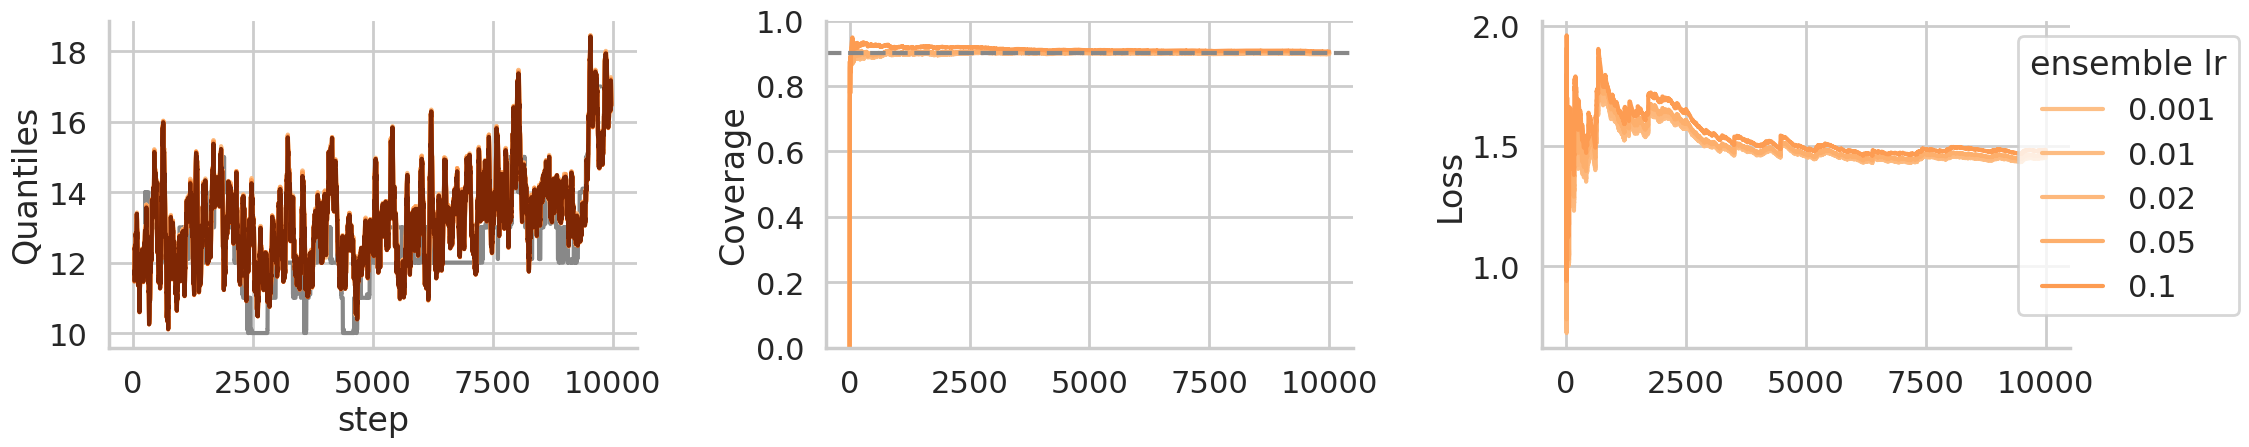

In [134]:
# Set styling
sns.set_style("whitegrid")
sns.set_context("poster")

sns.set_palette("pastel")

# Create color map
lr_cmap_log = plt.colormaps["Oranges"]
lr_cmap = LinearSegmentedColormap.from_list(
    "Custom", 
    lr_cmap_log(np.logspace(-0.5, 1, 100, base=10))
)

# Create the plot
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(23,5), sharex=True, sharey=False)


# Define rolling window size
window_size = 500

# Left plot: Rolling average for predictions
# True values (plot these first)
true_df = df[(df.lr == quantile_lr[0]) & (df.ensemble_lr == ensemble_lrs[0])].copy()
true_df['y_rolling'] = true_df['target'].rolling(window=window_size, center=True).quantile(q=0.9)
sns.lineplot(ax=axs[0], data=true_df,
            x="step", y="y_rolling", color="#888888",
            estimator=None, n_boot=0, label="True 90% quantile")

# Predictions for each learning rate (plot these last)
pred_df = df.copy()
pred_df['final_prediction'] = pred_df['prediction'] + pred_df['base_prediction']
pred_df['yhat_rolling'] = pred_df.groupby('ensemble_lr')['final_prediction'].transform(
    lambda x: x.rolling(window=window_size, center=True).mean()
)
_lp = sns.lineplot(ax=axs[0], data=pred_df,
                  x="step", y="yhat_rolling",
                  hue="lr", palette=lr_cmap,
                  estimator=None, n_boot=0,
                  hue_order=ensemble_lrs)
    
axs[0].set_ylabel("Quantiles")
_lp.get_legend().remove()

# Middle plot: Coverage
for ensemble_lr in ensemble_lrs:
    axs[1].plot(
        df[df.ensemble_lr == ensemble_lr].step,
        df[df.ensemble_lr == ensemble_lr]['covered'].expanding().mean(),
        color=lr_cmap(ensemble_lr)
    )
axs[1].set_ylabel("Coverage")
axs[1].set_ylim([0,1])
axs[1].axhline(0.9, color="#888888", linestyle='--')

# Right plot: Loss
for ensemble_lr in ensemble_lrs:
    axs[2].plot(
        df[df.ensemble_lr == ensemble_lr].step,
        df[df.ensemble_lr == ensemble_lr]['ensemble_loss'].expanding().mean(),
        color=lr_cmap(ensemble_lr),
        label=ensemble_lr
    )
axs[2].set_ylabel("Loss")
axs[2].legend(loc="upper right", bbox_to_anchor=(1.35,1), title='ensemble lr')

plt.tight_layout()
sns.despine(top=True, right=True)
os.makedirs('./plots/quantile_ensembling', exist_ok=True)
plt.savefig('./plots/quantile_ensembling/series.pdf')

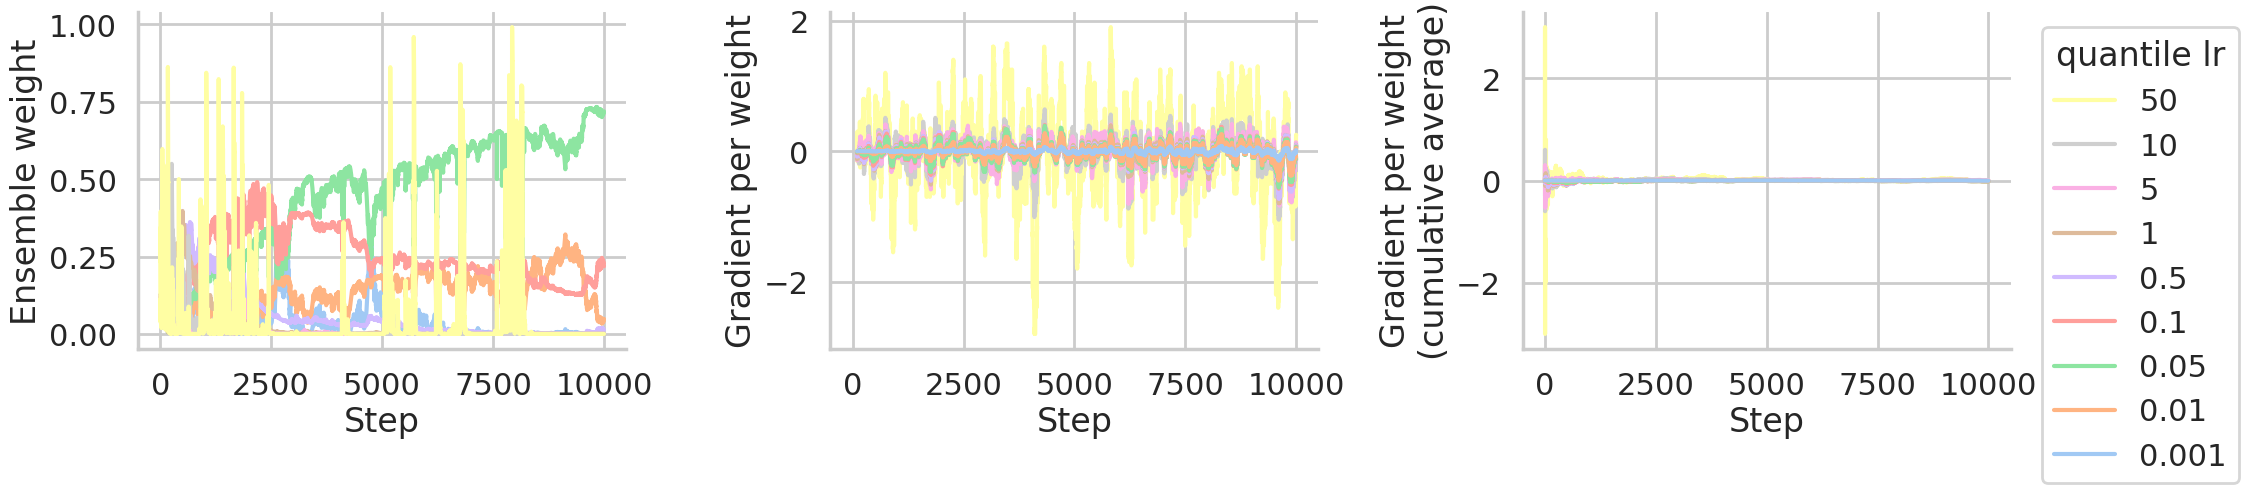

In [141]:
# Set styling
sns.set_style("whitegrid")
sns.set_context("poster")

sns.set_palette("pastel")

# Plot the ensemble weights over time for the default learning rate
default_ensemble_lr = 0.1

# Create the plot
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(23,5), sharex=True, sharey=False)

# Store the original colors from the first plot
# First, plot the first plot to capture the colors
colors = []
for i, lr in enumerate(quantile_lr):
    selector = (df['ensemble_lr'] == default_ensemble_lr) & (df['lr'] == lr)
    line, = axs[0].plot(df[selector]['step'], df[selector]['ensemble_weight'], label=f'lr={lr}')
    colors.append(line.get_color())
axs[0].set_xlabel('Step')
axs[0].set_ylabel('Ensemble weight')

# Clear the first subplot and replot with stored colors
axs[0].clear()
for i, (lr, color) in enumerate(zip(quantile_lr, colors)):
    selector = (df['ensemble_lr'] == default_ensemble_lr) & (df['lr'] == lr)
    axs[0].plot(df[selector]['step'], df[selector]['ensemble_weight'], label=f'lr={lr}', color=color)
axs[0].set_xlabel('Step')
axs[0].set_ylabel('Ensemble weight')

# Plot 2 (Rolling average): Use reversed order but match original colors
for i, (lr, color) in enumerate(zip(reversed(quantile_lr), reversed(colors))):
    selector = (df['ensemble_lr'] == default_ensemble_lr) & (df['lr'] == lr)
    temp = df[selector]['ensemble_weight_grad'].rolling(window=window_size).mean()
    axs[1].plot(df[selector]['step'], temp, label=f'lr={lr}', color=color)
axs[1].set_xlabel('Step')
axs[1].set_ylabel('Gradient per weight')

# Plot 3 (Cumulative average): Use reversed order but match original colors
for i, (lr, color) in enumerate(zip(reversed(quantile_lr), reversed(colors))):
    selector = (df['ensemble_lr'] == default_ensemble_lr) & (df['lr'] == lr)
    temp = df[selector]['ensemble_weight_grad'].expanding().mean()
    axs[2].plot(df[selector]['step'], temp, label=f'{lr}', color=color)
axs[2].set_xlabel('Step')
axs[2].set_ylabel('Gradient per weight\n(cumulative average)')
axs[2].legend(loc="upper right", bbox_to_anchor=(1.5,1), title='quantile lr')

plt.tight_layout()
sns.despine(top=True, right=True)
plt.savefig('./plots/quantile_ensembling/weights.pdf')